In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../model')
import mol_metrics as mm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools
import random
import time
from collections import OrderedDict
from awesome_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
awesome_settings()

/home/beangoben/projects/ORGAN-chem/model
mol_metrics: reading SA model ...
loaded in 0.51082444190979
mol_metrics: reading NP model ...
loaded in 0.1043550968170166


## read dataset

Initial dataset size: (249456, 1)
After dataset size: (249456, 2)


,smiles,mol
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,

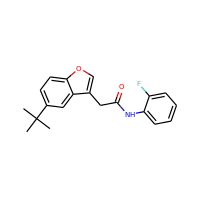

In [49]:
df = pd.read_csv('../data/drugs.smi',names=['smiles'])
print('Initial dataset size: {}'.format(str(df.shape)))
#df = df[ df['smiles'].apply(mm.verify_sequence).values ]
#df['smiles'] = df['smiles'].apply(mm.canon_smile)
PandasTools.AddMoleculeColumnToFrame(df,'smiles','mol')
print('After dataset size: {}'.format(str(df.shape)))
df.head(1)

## text properties

In [48]:
test_df = df.sample(n=25000)
test_df['n_atoms'] = test_df['mol'].apply(lambda m: m.GetNumAtoms() )
y = test_df['n_atoms']
sns.distplot(y)
stats_box(y)
sns.despine(offset=True)
plt.show()
test_df['txt_len'] = test_df['smiles'].apply(lambda s: len(s) )
y = test_df['txt_len']
sns.distplot(y)
stats_box(y)
sns.despine(offset=True)
plt.show()
y = test_df['txt_len']/test_df['n_atoms']
sns.distplot(y)
stats_box(y)
sns.despine(offset=True)
plt.show()

KeyError: 'mol'

## test all

In [11]:
test_n = 10
test_df = df.sample(n=25000)
smiles = list(test_df.iloc[:test_n].smiles.values)
train_smiles = list(test_df.iloc[test_n:].smiles.values)

metrics = mm.get_metrics()
for key,func in metrics.items():
    start = time.time()
    func(smiles, train_smiles)
    end = time.time()
    print("{:20s} computed in {:.7f} s".format(key,end - start))

/home/beangoben/projects/ORGAN-chem/model
mol_metrics: reading SA model ...
loaded in 0.49277615547180176
mol_metrics: reading NP model ...
loaded in 0.0974271297454834
validity             computed in 0.0023029 s
novelty              computed in 0.0095282 s
creativity           computed in 16.1289668 s
hard_novelty         computed in 0.0145199 s
soft_novelty         computed in 0.0090518 s
diversity            computed in 0.0421128 s
variety              computed in 0.0069973 s
symmetry             computed in 2.2530456 s
conciseness          computed in 0.0057428 s
solubility           computed in 0.0088580 s
naturalness          computed in 0.0034146 s
synthesizability     computed in 0.0073869 s
lipinski             computed in 0.0122182 s
drug_candidate       computed in 0.0294294 s
chemical_beauty      computed in 0.0221858 s


## mapping tools

/home/beangoben/projects/ORGAN-chem/model
mol_metrics: reading SA model ...
loaded in 0.48832082748413086
mol_metrics: reading NP model ...
loaded in 0.09591960906982422


/home/beangoben/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


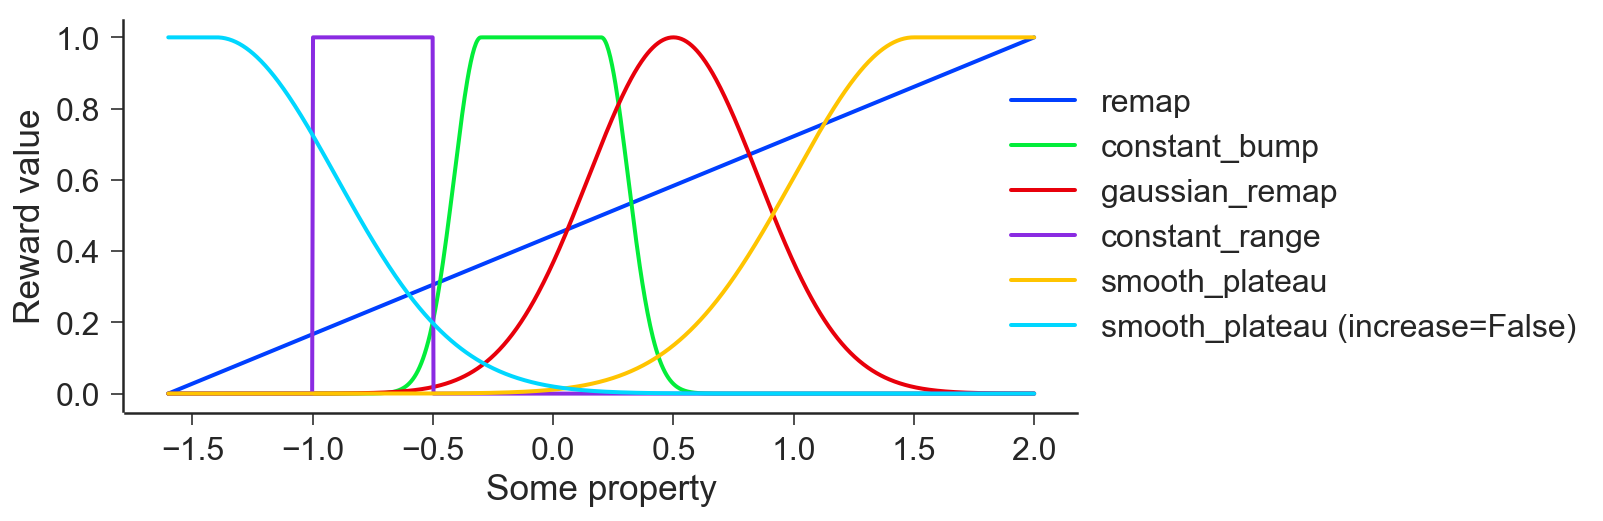

In [47]:
x = np.linspace(-1.6,2,1000)
x_min, x_max = np.min(x),np.max(x)
y = mm.remap(x, x_min, x_max)
plt.plot(x,y,label='remap')
y = mm.constant_bump(x,-0.3,0.2,0.025)
plt.plot(x,y,label='constant_bump')
y = mm.gauss_remap(x,0.5,0.5)
plt.plot(x,y,label='gaussian_remap')
plt.legend(loc='best')
sns.despine(offset=True)
y = mm.constant_range(x,-1,-0.5)
plt.plot(x,y,label='constant_range')
plt.legend(loc='center left',bbox_to_anchor=(0.9, 0.5))
y = mm.smooth_plateau(x,1.5,0.5)
plt.plot(x,y,label='smooth_plateau')
plt.legend(loc='center left',bbox_to_anchor=(0.9, 0.5))
y = mm.smooth_plateau(x,-1.4,0.5,False)
plt.plot(x,y,label='smooth_plateau (increase=False)')
plt.legend(loc='center left',bbox_to_anchor=(0.9, 0.5))
sns.despine(offset=True)
plt.xlabel('Some property')
plt.ylabel('Reward value')
plt.show()

## drug candidates

reading NP model ...
loaded in 0.10200333595275879


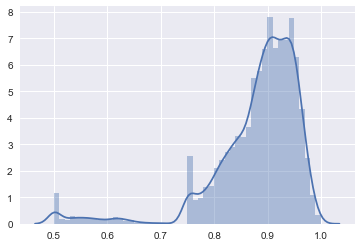

In [56]:
sns.distplot(d)

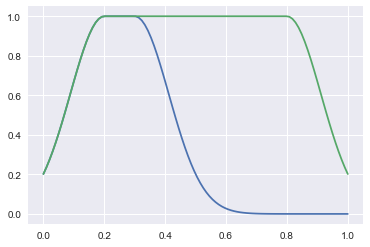

In [66]:
def constant_bump(x,x_low,x_high,decay):
    if x <= x_low:
        return np.exp(-(x-x_low)**2/decay)
    elif x >= x_high:
        return np.exp(-(x-x_high)**2/decay)
    else:
        return 1
    return 

x = np.linspace(0,1,100)
y = [ constant_bump(xi,0.2,0.3,0.025) for xi in x]
plt.plot(x,y)
y = [ constant_bump(xi,0.2,0.8,0.025) for xi in x]
plt.plot(x,y)

# Conciseness

In [23]:
def canon_smile(smile):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smile))


def conciseness(smile):
    canon = canon_smile(smile)
    diff_len= len(canon)-len(smile)
    val = np.clip(diff_len,0.0,20)
    val = 1-1.0/20.0*val
    return val

test_df = df.sample(n=20000)
test_df['compact'] = test_df['smiles'].apply(conciseness )


In [81]:
m = Chem.MolFromSmiles('N11')


# Substructure match

In [30]:
np.max(test_df['compact'])

def substructure_match(smile,sub_mol):
    mol = Chem.MolFromSmiles(smile)
    val = mol.HasSubstructMatch(sub_mol)
    return int(val)

ben = Chem.MolFromSmiles('C1=CC=CC=C1')

substructure_match('O=N1=CC=CC=C1',ben)

0

# Solubility

In [17]:
def solubility(mol):
    return Crippen.MolLogP(mol)

def normalize(sol):
    sol = remap(sol,-1.12871566316,6.0429063424)
    return np.clip(sol,0.0,1.0)
df['sol'] = df['mol'].apply(solubility)

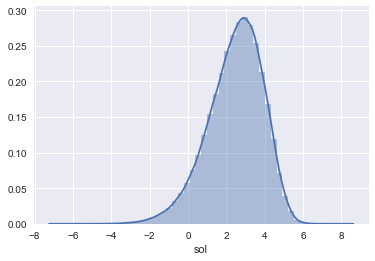

-1.12871566316 6.0429063424


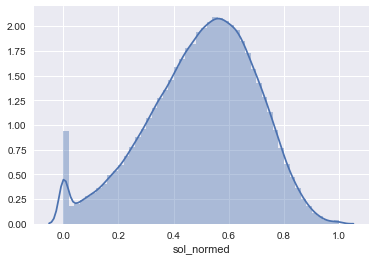

In [19]:
sns.distplot(df['sol'])
plt.show()

mean_s = np.mean(df['sol'].values)
std_s = np.std(df['sol'].values)
print(mean_s-2.5*std_s,mean_s+2.5*std_s)
df['sol_normed'] = df['sol'].apply(normalize)
sns.distplot(df['sol_normed'])
plt.show()

# Diversity
## Tests for range of values

In [4]:
def tanimoto_1d(fps):
    ds=[]
    for i in range(1,len(fps)):
        ds.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i],returnDistance=True))
    return ds

def ref_distance_set(ref_fps,set_fps):
    return 
    
def diverse_set(df,n_diverse):
    # get diverse molecules
    mmp = SimDivFilters.MaxMinPicker()
    ds = tanimoto_1d(df['fps'].values)
    ids= list(mmp.Pick(np.array(ds),len(df),n_diverse))
    non_ids = [ i for i in range(len(df)) if i not in ids]
    # diverse and non diverse molecules
    div_df = df.iloc[ids]
    nondiv_df = df.iloc[non_ids]
    return div_df,nondiv_df

In [5]:
df['fps']= df['mol'].apply( lambda m: Chem.GetMorganFingerprintAsBitVect(m,4,nBits=2048))

0.935149558455 0.913826919605


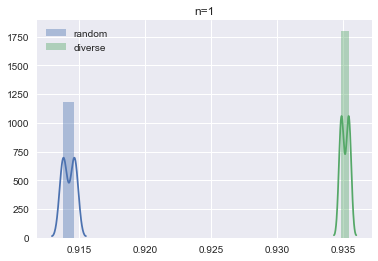

0.934596818642 0.913288372218


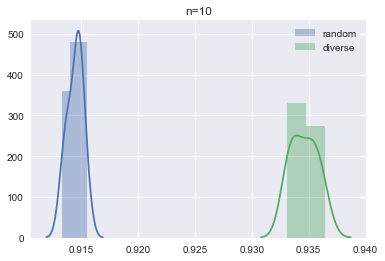

0.934838906731 0.913288372218


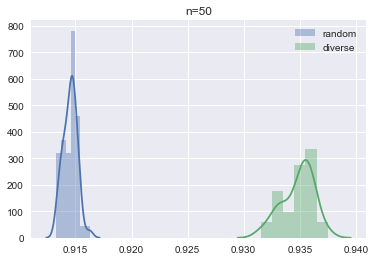

0.934775167349 0.913014739801


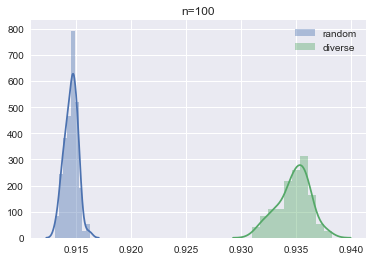

0.934731447983 0.913014739801


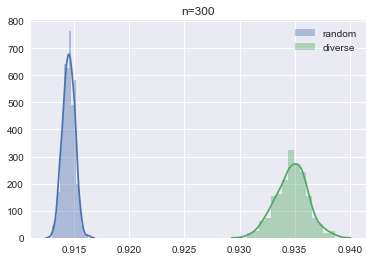

KeyboardInterrupt: 

In [16]:
n=10
n_exp=1000
mean_rand=[]
mean_div=[]

for i in range(1,n_exp+1):
    sub_df = df.sample(n=n*100)
    div_df, non_df = diverse_set(sub_df,n*5)
    rand_df = df.sample(n=n*100)   
    div_dst = [ref_distance_set(ref,rand_df['fps'].values) for ref in div_df['fps'].values ]
    non_dst = [ref_distance_set(ref,rand_df['fps'].values) for ref in non_df['fps'].values ]
    mean_div.append(np.mean(div_dst))
    mean_rand.append(np.mean(non_dst))
    if i in [1,10,50,100,250,500,1000]:
        print(np.mean(mean_div),np.min(mean_rand))
        sns.distplot(mean_rand,label='random')
        sns.distplot(mean_div,label='diverse')
        plt.title('n={}'.format(i))
        plt.legend(loc='best')
        plt.show()

## how does this scale with number of samples

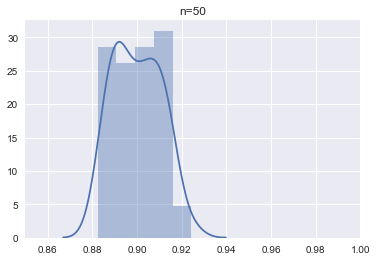

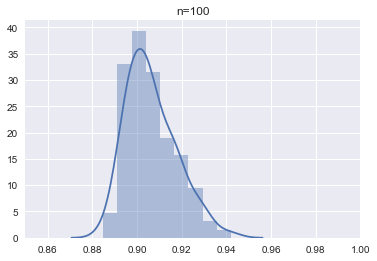

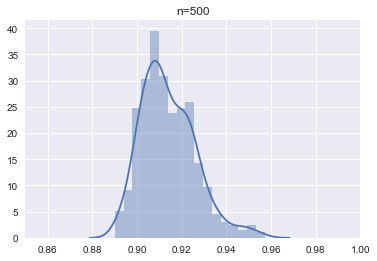

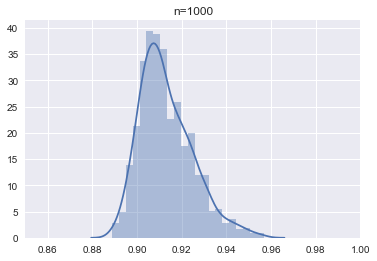

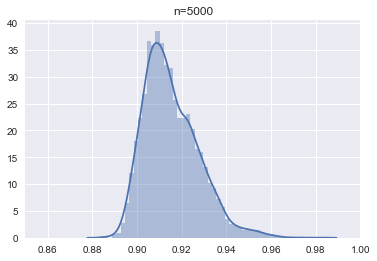

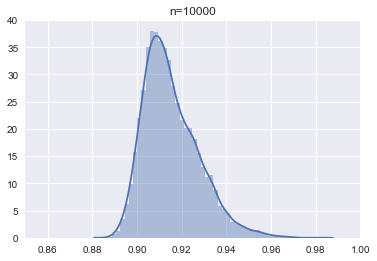

In [28]:
for i in [50,100,500,1000,5000,10000]:
    rand_df = df.sample(n=i)
    dst=[ref_distance_set(ref,rand_df['fps'].values) for ref in rand_df['fps'].values ]
    sns.distplot(dst)
    plt.title('n={}'.format(i))
    plt.xlim([0.85,1.0])
    plt.show()

## functionalize

In [59]:
def batch_diversity(smiles, train_smiles):
    rand_smiles = random.sample(train_smiles,100)
    rand_mols = [Chem.MolFromSmiles(s) for s in rand_smiles]
    fps =[Chem.GetMorganFingerprintAsBitVect(m,4,nBits=2048) for m in rand_mols]
    vals = [diversity(smile,fps) for smile in smiles]
    return vals


def diversity(smile, fps):
    low_rand_dst = 0.9
    mean_div_dst = 0.945
    ref_mol = Chem.MolFromSmiles(smile)
    ref_fps = Chem.GetMorganFingerprintAsBitVect(ref_mol, 4, nBits=2048)
    dist = DataStructs.BulkTanimotoSimilarity(
        ref_fps, fps, returnDistance=True)
    mean_dist = np.mean(np.array(dist))
    val = remap(mean_dist, low_rand_dst, mean_div_dst)
    val = np.clip(val, 0.0, 1.0)
    return val

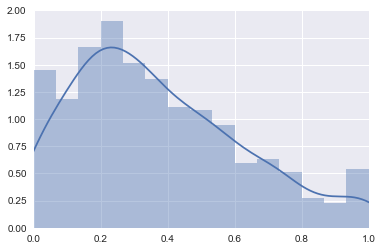

In [60]:
test_df = df.sample(n=10000)
smiles = test_df.iloc[:1000].smiles
train_smiles = list(test_df.iloc[1000:].smiles)
div = batch_diversity(smiles, train_smiles)
sns.distplot(div)
plt.xlim([0,1])
plt.show()

# Naturalness AKA Natural Products

In [84]:
import time
import pickle
import gzip
import numpy as np

def readNPModel(filename='NP_score.pkl.gz'):
    print("reading NP model ...")
    start = time.time()
    NP_model = pickle.load(gzip.open(filename))
    end = time.time()
    print("loaded in {}".format(end - start))
    return NP_model

def NP_score(smile):
    mol = Chem.MolFromSmiles(smile)
    fp = Chem.GetMorganFingerprint(mol, 2)
    bits = fp.GetNonzeroElements()

    # calculating the score
    score = 0.
    for bit in bits:
        score += NP_model.get(bit, 0)
    score /= float(mol.GetNumAtoms())

    # preventing score explosion for exotic molecules
    if score > 4:
        score = 4. + math.log10(score - 4. + 1.)
    if score < -4:
        score = -4. - math.log10(-4. - score + 1.)
    val = np.clip(remap(score,-3,1),0.0,1.0)
    return val

NP_model = readNPModel()

def batch_NPLikeliness(smiles,train_smiles=None):
    scores = [ NP_score(s) for s in smiles]
    return scores

reading NP model ...
loaded in 0.108917236328125


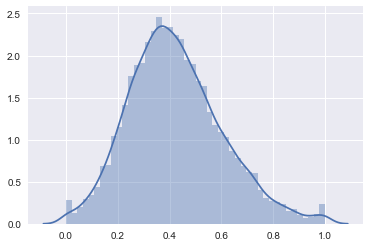

In [81]:
test_df = df.sample(n=10000)
smiles = test_df.smiles
np_like = batch_NPLikeliness(smiles)
sns.distplot(np_like)
plt.show()

# Synthezizable

In [110]:
import math
def readSAModel(filename='SA_score.pkl.gz'):
    model_data = pickle.load(gzip.open(filename))
    outDict = {}
    for i in model_data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    SA_model = outDict
    return SA_model


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = Chem.CalcNumSpiroAtoms(mol)
    nBridgehead = Chem.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro

def SA_score(smile):
    mol = Chem.MolFromSmiles(smile)
    # fragment score
    fp = Chem.GetMorganFingerprint(mol,2) 
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    #for bitId, v in fps.items():
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += SA_model.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = mol.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
    ri = mol.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(mol, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - \
        spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0
    val = remap(sascore,5,1.5)
    val = np.clip(val,0.0,1.0)
    return val

def batch_SA(smiles,train_smiles=None):
    scores = [ SA_score(s) for s in smiles]
    return scores

SA_model = readSAModel()

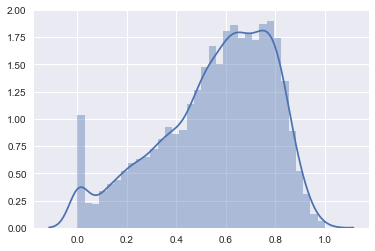

In [111]:
test_df = df.sample(n=10000)
smiles = test_df.smiles
vals = batch_SA(smiles)
sns.distplot(vals)
plt.show()